In [12]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import random 
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch 
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [13]:
# Load the datasets
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape: (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [14]:
# Train-validation split
X_full = train_df["Review Comment"]
y_full = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.10, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [15]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def embed(texts):
    return embedder.encode(
        texts.tolist(), show_progress_bar=True, batch_size=64, device=device
    )

Xtr_emb = embed(X_train)
Xval_emb = embed(X_val)

Batches: 100%|██████████| 2/2 [00:00<00:00, 28.71it/s]


In [16]:
param_grid = {"C": [0.1, 0.5, 1, 2, 5, 10]}
base_lr = LogisticRegression(
    penalty="l2", solver="saga", max_iter=1000, multi_class="multinomial", n_jobs=-1
)

search = GridSearchCV(
    base_lr, param_grid, cv=5, n_jobs=-1, scoring="accuracy", verbose=1
)
search.fit(Xtr_emb, y_train)

print("Best CV-acc:", search.best_score_)
print("Best C:", search.best_params_["C"])
best_lr = search.best_estimator_


/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/linear_model/

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV-acc: 0.5542985457656117
Best C: 0.5


In [17]:
X_full_emb = embed(X_full)
final_model = best_lr if "best_lr" in globals() else base_lr
final_model.fit(X_full_emb, y_full)

Batches: 100%|██████████| 15/15 [00:00<00:00, 70.45it/s]


LogisticRegression(C=0.5, max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga')

Batches: 100%|██████████| 4/4 [00:00<00:00, 33.86it/s]



Test accuracy: 0.5726

              precision    recall  f1-score   support

      delete       0.62      0.59      0.61        78
      insert       0.55      0.57      0.56        81
     replace       0.55      0.56      0.55        75

    accuracy                           0.57       234
   macro avg       0.57      0.57      0.57       234
weighted avg       0.57      0.57      0.57       234



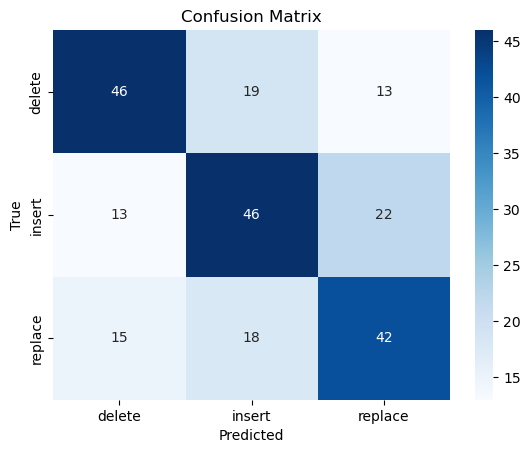

In [18]:
X_test  = test_df["Review Comment"].astype(str)
y_test  = test_df["Expected Operation by Developer"]
Xtest_emb = embed(X_test)

y_pred = final_model.predict(Xtest_emb)
acc    = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_full))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_full),
            yticklabels=np.unique(y_full))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [19]:
feat_dim = final_model.coef_.shape[1]
for cls, vec in zip(final_model.classes_, final_model.coef_):
    top10 = np.argsort(vec)[-10:][::-1]
    print(f"\nClass '{cls}' - strongest dims:", top10)



Class 'delete' - strongest dims: [376 136 317 261 206   4 299 382 144   8]

Class 'insert' - strongest dims: [ 87 286 114  46  22 131 375 298 151  86]

Class 'replace' - strongest dims: [201  18  70 149 209  66 363 226 286 280]
